# Hunting for Exoplanets   
## Initial Data Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import signal
from  scipy import ndimage
import matplotlib
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# import jupyternotify
# ip = get_ipython()
# ip.register_magics(jupyternotify.JupyterNotifyMagics)

In [2]:
extrain = pd.read_csv('data/exoTrain.csv')
extest = pd.read_csv('data/exoTest.csv')

What does the data look like?

In [3]:
extrain.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Each row has a label and tnen time series of light flux.  

According to [NASA](https://keplerscience.arc.nasa.gov/k2-observing.html),
> K2 observations entail a series of sequential observing "Campaigns" of fields distributed around the ecliptic plane. Each ecliptic Campaign is limited by Sun angle constraints to a duration of approximately 80 days as illustrated in the image below (Howell et al. 2014). Therefore, four to five K2 Campaigns can be performed during each 372-day orbit of the spacecraft.  
![kepler campaigns](https://www.nasa.gov/sites/default/files/k2_explained_25nov_story.jpg)

Therefore, observations are (80 days) / (3197 columns) or approximately 36 minutes apart, i.e. the sampling frequency is 1 / (36 minutes * 60 seconds in a minute) or 0.00046 Hz.

What does the flux look like for a star without confirmed exoplanets vs. a star with confirmed exoplanets?

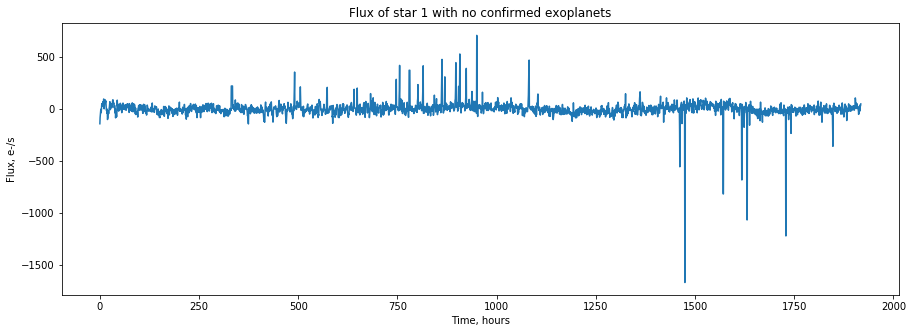

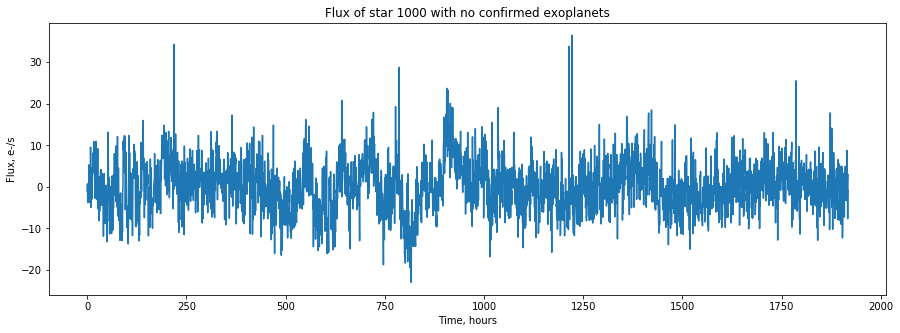

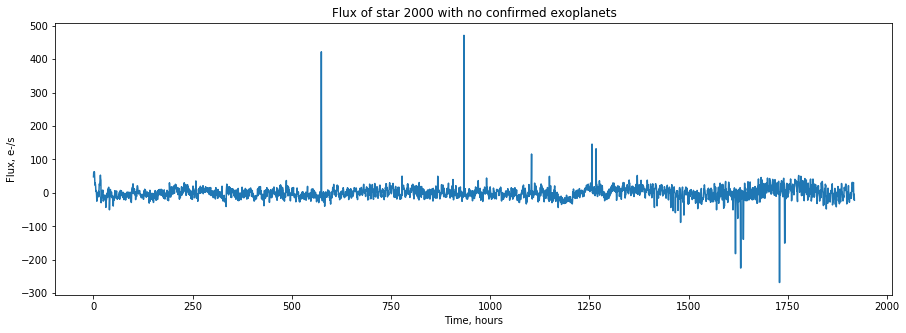

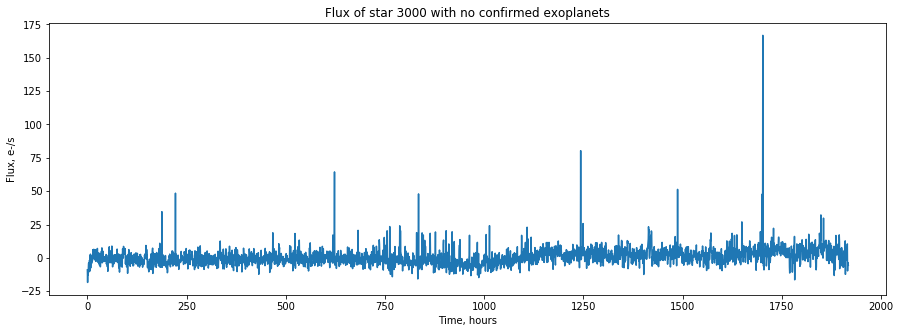

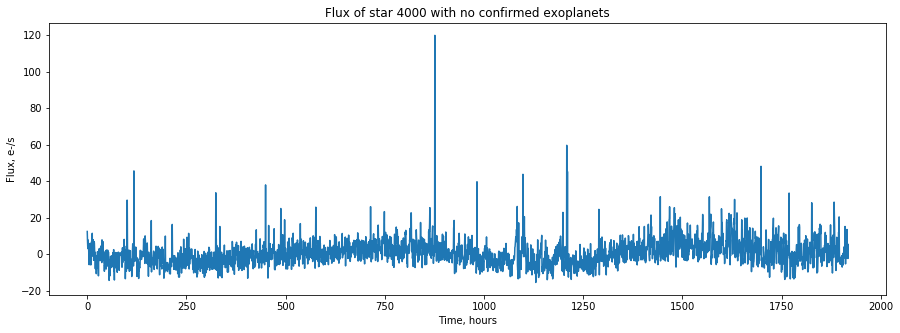

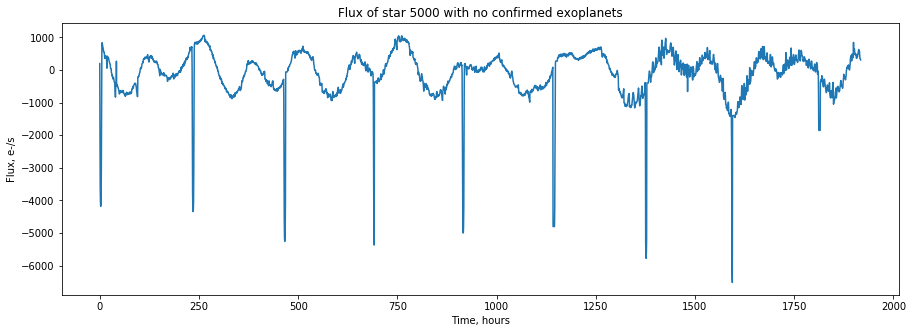

In [4]:
# Obtaining flux for several stars without exoplanets from the train data:
for i in [0, 999, 1999, 2999, 3999, 4999]:
    flux = extrain[extrain.LABEL == 1].drop('LABEL', axis=1).iloc[i,:]
    time = np.arange(len(flux)) * (36.0/60.0) # time in units of hours
    plt.figure(figsize=(15,5))
    plt.title('Flux of star {} with no confirmed exoplanets'.format(i+1))
    plt.ylabel('Flux, e-/s')
    plt.xlabel('Time, hours')
    plt.plot(time, flux)

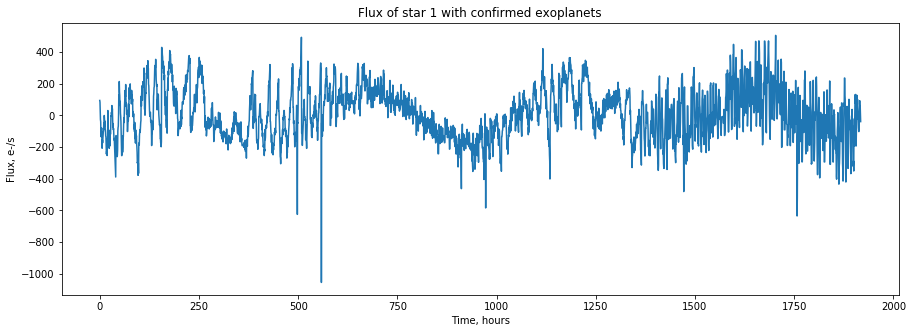

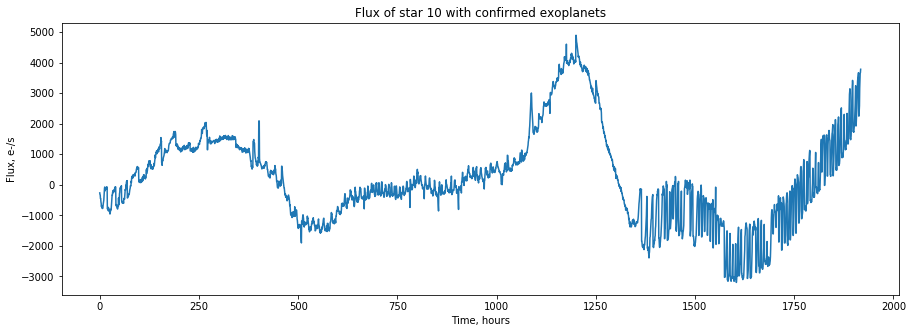

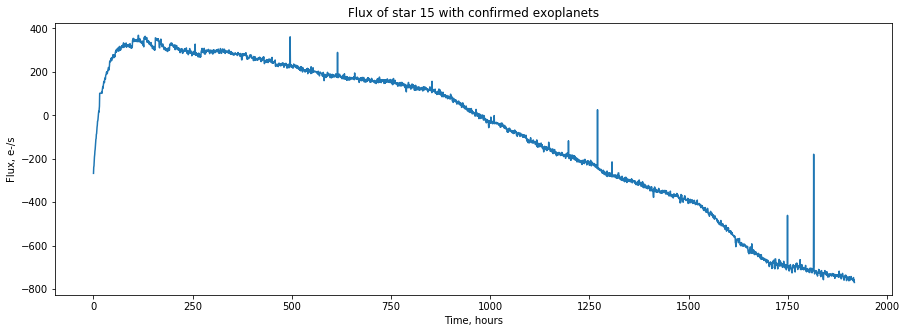

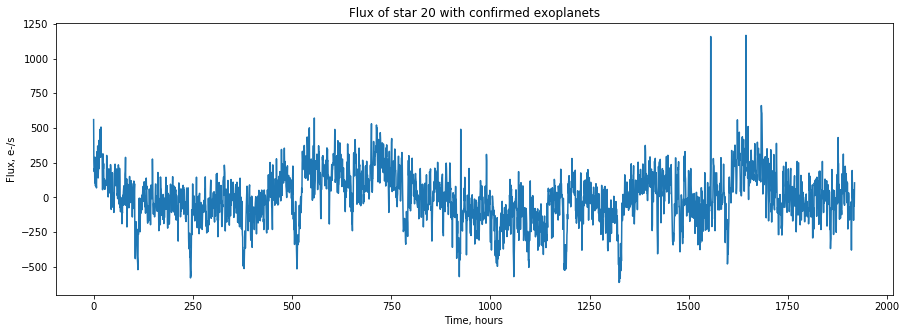

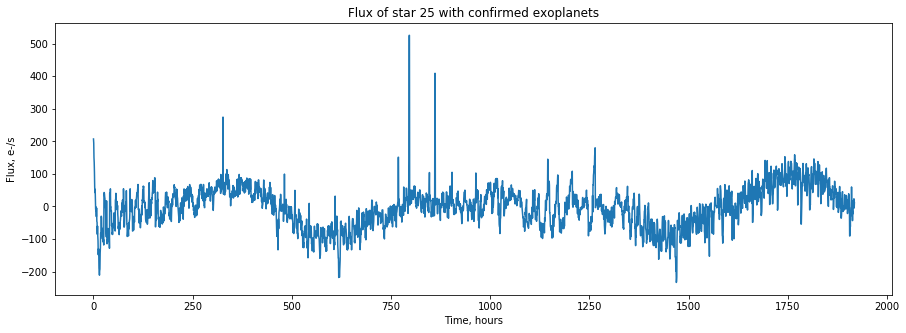

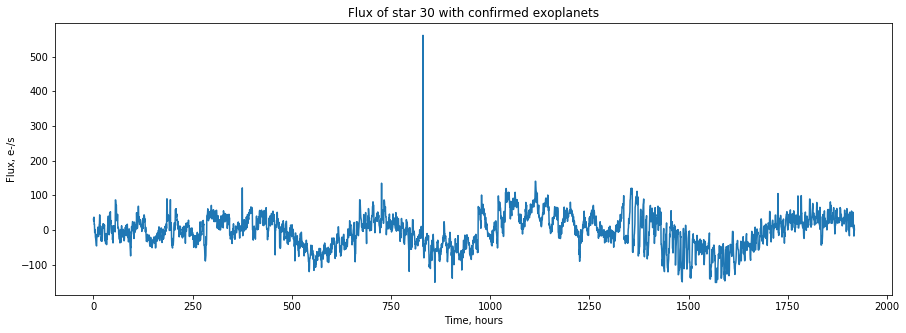

In [5]:
# Obtaining flux for several stars without exoplanets from the train data:
for i in [0, 9, 14, 19, 24, 29]:
    flux = extrain[extrain.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
    time = np.arange(len(flux)) * (36.0/60.0) # time in units of hours
    plt.figure(figsize=(15,5))
    plt.title('Flux of star {} with confirmed exoplanets'.format(i+1))
    plt.ylabel('Flux, e-/s')
    plt.xlabel('Time, hours')
    plt.plot(time, flux)

There are a lot of different shapes and magnitudes in the data. Therefore, the data needs to be transformed to one single standard in order for us to produce a better model:  

### 1. Detrend data  
We have noticed many different shapes in the signal. Removing any trends can go a long way in further processing:

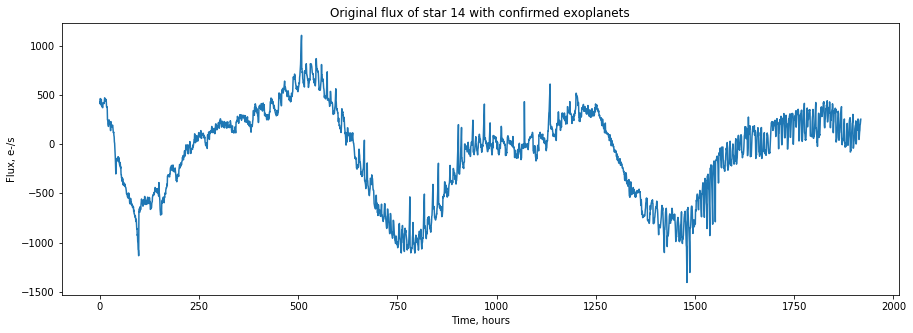

In [6]:
i = 13
flux1 = extrain[extrain.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
time = np.arange(len(flux1)) * (36.0/60.0) # time in units of hours
plt.figure(figsize=(15,5))
plt.title('Original flux of star {} with confirmed exoplanets'.format(i+1))
plt.ylabel('Flux, e-/s')
plt.xlabel('Time, hours')
plt.plot(time, flux1)

In order to detrend, we need to find a general shape of the signal which we can then subtract it form the original signal to get its relatively flat representation. I decided to use Gaussian smoothing:

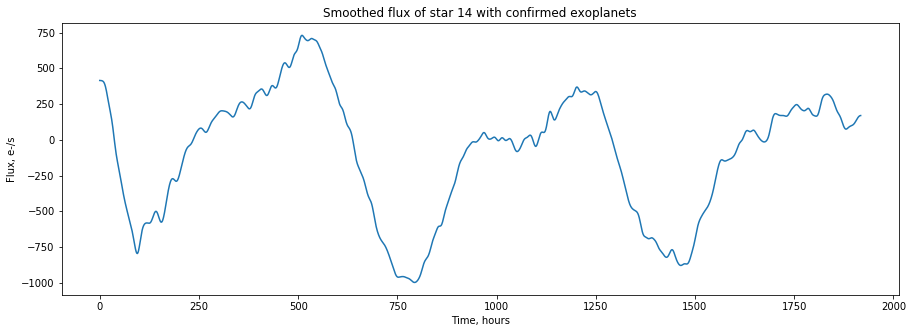

In [7]:
i = 13
flux2 = ndimage.filters.gaussian_filter(flux1, sigma=10)
time = np.arange(len(flux2)) * (36.0/60.0) # time in units of hours
plt.figure(figsize=(15,5))
plt.title('Smoothed flux of star {} with confirmed exoplanets'.format(i+1))
plt.ylabel('Flux, e-/s')
plt.xlabel('Time, hours')
plt.plot(time, flux2)

Detrend the signal:

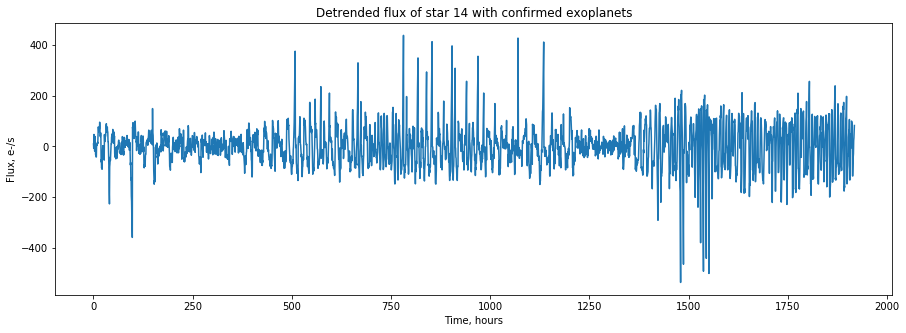

In [8]:
i = 13
flux3 = flux1 - flux2
time = np.arange(len(flux3)) * (36.0/60.0) # time in units of hours
plt.figure(figsize=(15,5))
plt.title('Detrended flux of star {} with confirmed exoplanets'.format(i+1))
plt.ylabel('Flux, e-/s')
plt.xlabel('Time, hours')
plt.plot(time, flux3)

### 2. Normalize the detrended signal

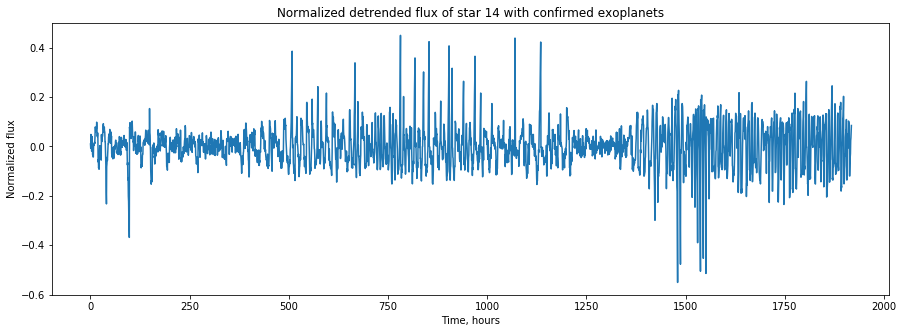

In [9]:
i = 13
flux3normalized = (flux3-np.mean(flux3))/(np.max(flux3)-np.min(flux3))
time = np.arange(len(flux3normalized)) * (36.0/60.0) # time in units of hours
plt.figure(figsize=(15,5))
plt.title('Normalized detrended flux of star {} with confirmed exoplanets'.format(i+1))
plt.ylabel('Normalized flux')
plt.xlabel('Time, hours')
plt.plot(time, flux3normalized)

Let's apply this process to the entirety of the data:

In [10]:
def detrender_normalizer(X):
    flux1 = X
    flux2 = ndimage.filters.gaussian_filter(flux1, sigma=10)
    flux3 = flux1 - flux2
    flux3normalized = (flux3-np.mean(flux3)) / (np.max(flux3)-np.min(flux3))
    return flux3normalized

In [11]:
extrain.iloc[:,1:] = extrain.iloc[:,1:].apply(detrender_normalizer,axis=1)
extest.iloc[:,1:] = extest.iloc[:,1:].apply(detrender_normalizer,axis=1)

In [12]:
extrain.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,0.106403,0.100007,0.058134,0.027612,0.020326,-0.035103,-0.040581,-0.013007,-0.000332,...,-0.046745,-0.064083,-0.065208,0.018642,0.033445,0.062076,0.026078,0.040409,0.002601,-0.027266
1,2,0.041485,0.050703,0.003597,0.037446,-0.037595,-0.026886,-0.054623,-0.054545,-0.054560,...,0.007640,-0.047580,-0.048278,-0.035134,0.002010,0.012103,-0.011757,0.022125,0.039876,0.047170
2,2,0.036390,0.039271,0.018812,0.003153,-0.034190,-0.026011,-0.027999,-0.008730,-0.054926,...,-0.035135,0.042446,0.042538,0.003252,0.011593,0.035374,0.020106,0.004589,-0.032843,-0.057117
3,2,0.019349,0.081422,-0.052651,-0.065242,-0.006866,-0.021728,0.007249,-0.024948,-0.020675,...,0.038329,0.008620,0.007142,0.106338,0.075364,-0.022922,-0.012111,-0.038125,-0.038649,0.054377
4,2,-0.058758,-0.061891,-0.066326,-0.059138,-0.047121,-0.041884,-0.031973,-0.047753,-0.040327,...,-0.038013,0.038773,0.036134,0.052166,0.014349,0.014799,0.029481,0.034669,0.022747,-0.018448


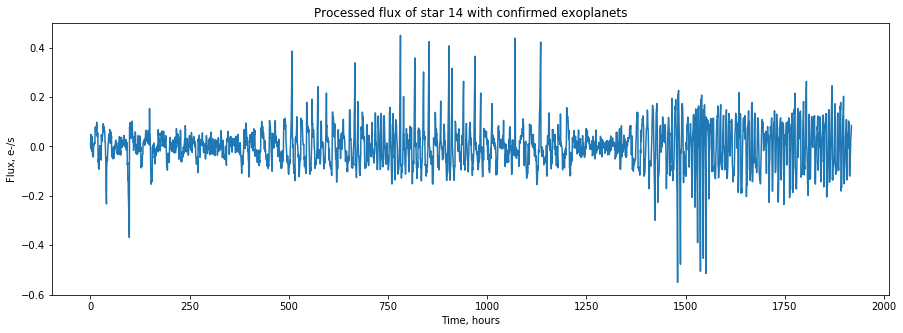

In [13]:
i = 13
flux1 = extrain[extrain.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
flux1 = flux1.reset_index(drop=True)
time = np.arange(len(flux1)) * (36.0/60.0) # time in units of hours
plt.figure(figsize=(15,5))
plt.title('Processed flux of star {} with confirmed exoplanets'.format(i+1))
plt.ylabel('Flux, e-/s')
plt.xlabel('Time, hours')
plt.plot(time, flux1)

Since we are looking for dips in flux when exoplanets pass between the telescope and the star, we should remove any upper outliers:

In [14]:
def reduce_upper_outliers(df,reduce = 0.01, half_width=4):
    '''
    Since we are looking at dips in the data, we should remove upper outliers.
    The function is taken from here:
    https://www.kaggle.com/muonneutrino/exoplanet-data-visualization-and-exploration
    '''
    length = len(df.iloc[0,:])
    remove = int(length*reduce)
    for i in df.index.values:
        values = df.loc[i,:]
        sorted_values = values.sort_values(ascending = False)
       # print(sorted_values[:30])
        for j in range(remove):
            idx = sorted_values.index[j]
            #print(idx)
            new_val = 0
            count = 0
            idx_num = int(idx[5:])
            #print(idx,idx_num)
            for k in range(2*half_width+1):
                idx2 = idx_num + k - half_width
                if idx2 <1 or idx2 >= length or idx_num == idx2:
                    continue
                new_val += values['FLUX.'+str(idx2)] # corrected from 'FLUX-' to 'FLUX.'
                
                count += 1
            new_val /= count # count will always be positive here
            #print(new_val)
            if new_val < values[idx]: # just in case there's a few persistently high adjacent values
                df.set_value(i,idx,new_val)
        
            
    return df

In [15]:
extrain.iloc[:,1:] = reduce_upper_outliers(extrain.iloc[:,1:])
extest.iloc[:,1:] = reduce_upper_outliers(extest.iloc[:,1:])

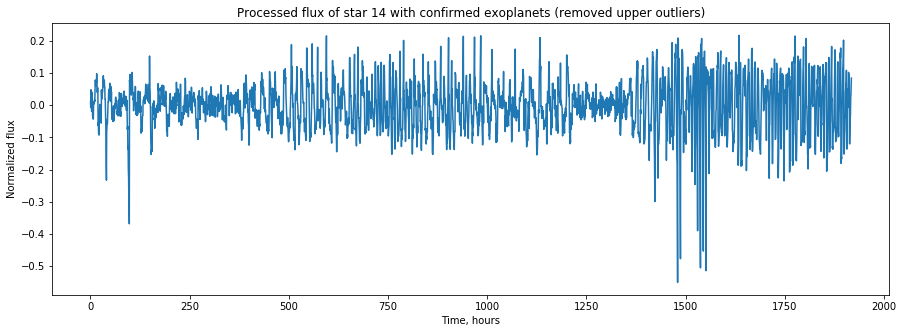

In [16]:
i = 13
flux1 = extrain[extrain.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
flux1 = flux1.reset_index(drop=True)
time = np.arange(len(flux1)) * (36.0/60.0) # time in units of hours
plt.figure(figsize=(15,5))
plt.title('Processed flux of star {} with confirmed exoplanets (removed upper outliers)'.format(i+1))
plt.ylabel('Normalized flux')
plt.xlabel('Time, hours')
plt.plot(time, flux1)

## Baseline Model
Before we try to generate any features from the data, let's see if we can get any good models just by feeding them raw data

In [17]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

/Users/abalakrishna/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


There is a huge imbalance in classes with LABEL = 1 (no exoplanets) being the dominant class:

In [18]:
extrain.LABEL.value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

In [19]:
extest.LABEL.value_counts()

1    565
2      5
Name: LABEL, dtype: int64

That means that I will have to perform test-train splits with stratification.

Therefore, we either need to bootstrap the data to get more LABEL = 2 observations, or we can synthetically generate new data using SMOTE approach, see more information [here](https://beckernick.github.io/oversampling-modeling/). Bootstrapping/using SMOTE with impbalanced data should proceed in the following order:
1. Perform stratified test-train separation on the data
2. Boostrap/use SMOTE on the train data, leave test data untouched
3. Perform model fit on the bootstrapped train data
4. Assess you model's performance using untouched test data  
The code below also performs K-fold validation with the default of 5 folds:

In [20]:
from imblearn.over_sampling import SMOTE

In [90]:
def model_evaluator(X, y, model, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits)
    
    bootstrapped_accuracies = list()
    bootstrapped_precisions = list()
    bootstrapped_recalls    = list()
    
    for train_index, test_index in skf.split(X, y):
        print 'in loop'
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
                
        df_train    = X_train.join(y_train)
        df_planet   = df_train[df_train.LABEL == 2].reset_index(drop=True)
        df_noplanet = df_train[df_train.LABEL == 1].reset_index(drop=True)
        df_boot     = df_noplanet
                        
        index = np.arange(0, df_planet.shape[0])
        temp_index = np.random.choice(index, size=df_noplanet.shape[0])
        df_boot = df_boot.append(df_planet.iloc[temp_index])
        
        df_boot = df_boot.reset_index(drop=True)
        X_train_boot = df_boot.drop('LABEL', axis=1)
        y_train_boot = df_boot.LABEL
                    
        est_boot = model.fit(X_train_boot, y_train_boot)
        y_test_pred = est_boot.predict(X_test)
        
        bootstrapped_accuracies.append(accuracy_score(y_test, y_test_pred))
        bootstrapped_precisions.append(precision_score(y_test, y_test_pred, pos_label=2))
        bootstrapped_recalls.append(recall_score(y_test, y_test_pred, pos_label=2))

    print "Average Accuracy"
    print np.mean(bootstrapped_accuracies)
    
    print "Average Precision"
    print np.mean(bootstrapped_precisions)
    
    print "Average Recall"
    np.mean(bootstrapped_recalls)

So, the baseline model evaluation is done below. First, let's see how we can model original raw unprocessed data:

NameError: name 'bootstrapped_recalls' is not defined

Now let's see how well we can fit a model using data that we have processed previously:

In [62]:
X = extrain.drop('LABEL', axis=1)
y = extrain.LABEL

In [63]:
model_evaluator(X, y, LinearSVC())

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
Average Accuracy
0.988009529261
Average Precision
0.252261904762
Average Recall
0.341666666667


![img](http://www.ragan.com/Resource.ashx?sn=Attention_Grabbing_Ways_to_Open_Blog_Posts)

It looks like K-nearest neighbors classifier works well for both processed and minimally processed data. The fit improved from f1 score of 0.149 from the KNN trained on raw bootstrapped data to f1 score of 0.576 from the KNN trained on minimally processed data expanded with SMOTE. Let's see if we could improve our model further.  

## Improving the model  

If exoplanets exist around any given star, they should revolve around the star with frequencies far smaller than flux noise and other electromagnetic phenomena affecting flux. Therefore, let's consider analyzing flux frequency spectrum rather than raw flux data. In theory, the presence of exoplanets should contribute to lower frequencies in the spectrum making them good features to use for identification of stars with potential exoplanets.

In [64]:
import scipy

In [65]:
def spectrum_getter(X):
    Spectrum = scipy.fft(X, n=X.size)
    return np.abs(Spectrum)

In [66]:
X_train = extrain.drop('LABEL', axis=1)
y_train = extrain.LABEL

X_test = extest.drop('LABEL', axis=1)
y_test = extest.LABEL

In [67]:
new_X_train = X_train.apply(spectrum_getter,axis=1)
new_X_test = X_test.apply(spectrum_getter,axis=1)

In [68]:
new_X_train.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,5.353950,2.793534,2.168319,2.218131,0.150812,2.359000,1.502987,1.062576,1.307456,1.866906,...,2.159928,1.866906,1.307456,1.062576,1.502987,2.359000,0.150812,2.218131,2.168319,2.793534
1,6.681330,3.293797,2.689292,4.497807,4.577738,3.716546,2.750151,4.821363,2.820160,3.397276,...,3.360527,3.397276,2.820160,4.821363,2.750151,3.716546,4.577738,4.497807,2.689292,3.293797
2,9.063000,5.392788,5.741762,4.986901,1.921782,1.599331,1.260012,2.730223,1.657274,2.056005,...,3.234700,2.056005,1.657274,2.730223,1.260012,1.599331,1.921782,4.986901,5.741762,5.392788
3,7.147779,4.232369,1.627227,2.187125,1.271097,3.536486,2.683690,1.970316,1.403851,1.946623,...,2.597172,1.946623,1.403851,1.970316,2.683690,3.536486,1.271097,2.187125,1.627227,4.232369
4,6.196115,3.322981,2.272814,2.227089,2.250706,1.785131,4.430069,1.562700,0.669993,0.184465,...,2.197994,0.184465,0.669993,1.562700,4.430069,1.785131,2.250706,2.227089,2.272814,3.322981


In [69]:
# Segregate data for desigining the model and for the final test
y = y_train
X = new_X_train

y_final_test = y_test
X_final_test = new_X_test

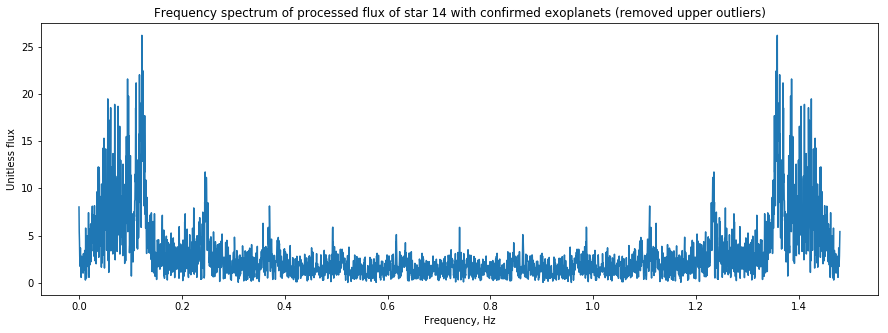

In [70]:
df = X.join(y)
i = 13
spec1 = df[df.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
freq = np.arange(len(spec1)) * (1/(36.0*60.0)) # Sampling frequency is 1 frame per ~36 minutes, or about 0.00046 Hz
plt.figure(figsize=(15,5))
plt.title('Frequency spectrum of processed flux of star {} with confirmed exoplanets (removed upper outliers)'
          .format(i+1))
plt.ylabel('Unitless flux')
plt.xlabel('Frequency, Hz')
plt.plot(freq, spec1)

Since [frequency spectra are symmetric](https://dsp.stackexchange.com/questions/4825/why-is-the-fft-mirrored), we need to remove half of all spectra:

In [108]:
X = X.iloc[:,:(X.shape[1]//2)]
X_final_test = X_final_test.iloc[:,:(X_final_test.shape[1]//2)]

Let's see what spectra look like for stars:

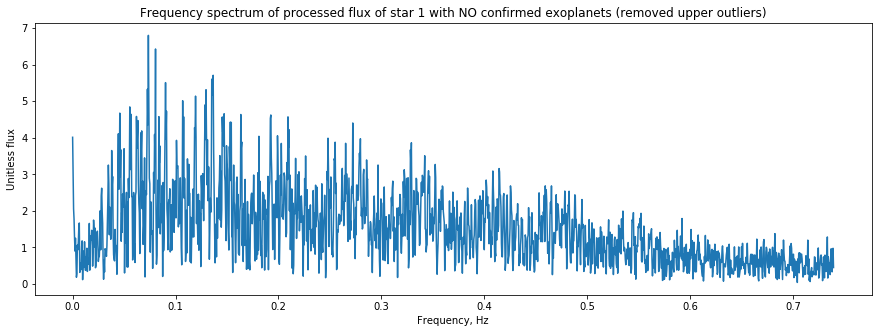

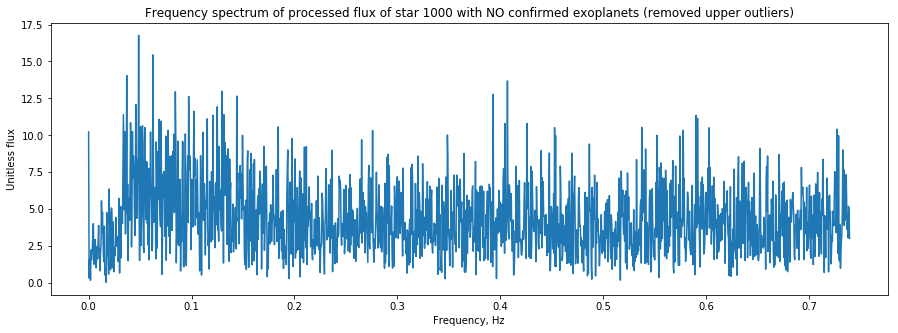

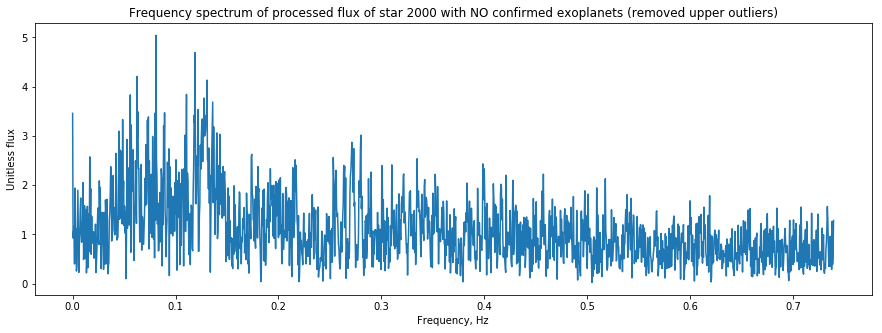

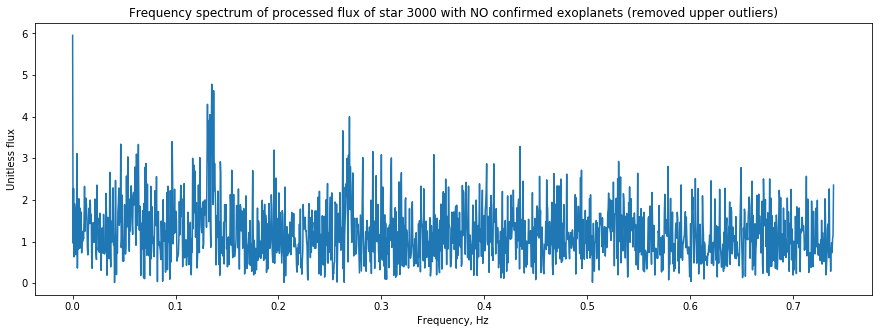

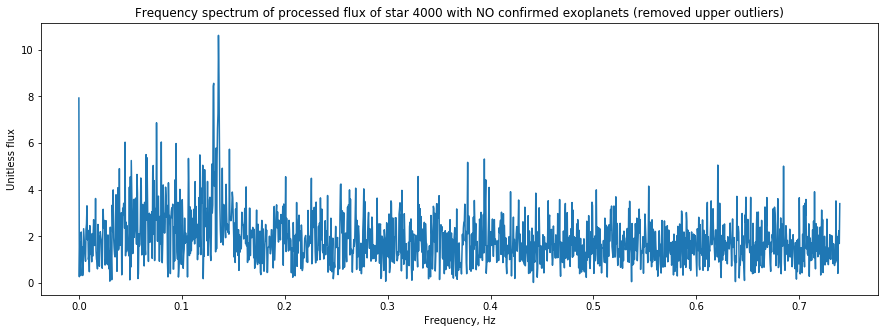

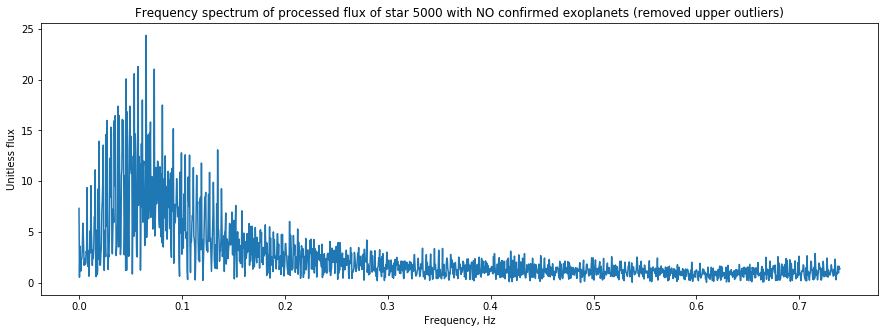

In [72]:
# Obtaining flux frequency spectra for several stars without exoplanets from the train data:
df = X.join(y)
for i in [0, 999, 1999, 2999, 3999, 4999]:
    spec1 = df[df.LABEL == 1].drop('LABEL', axis=1).iloc[i,:]
    freq = np.arange(len(spec1)) * (1/(36.0*60.0)) # Sampling frequency is 1 frame per ~36 minutes, or about 0.00046 Hz
    plt.figure(figsize=(15,5))
    plt.title('Frequency spectrum of processed flux of star {} with NO confirmed exoplanets (removed upper outliers)'
              .format(i+1))
    plt.ylabel('Unitless flux')
    plt.xlabel('Frequency, Hz')
    plt.plot(freq, spec1)

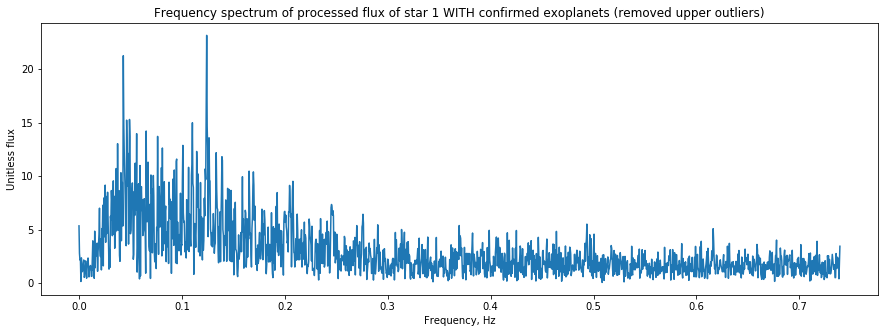

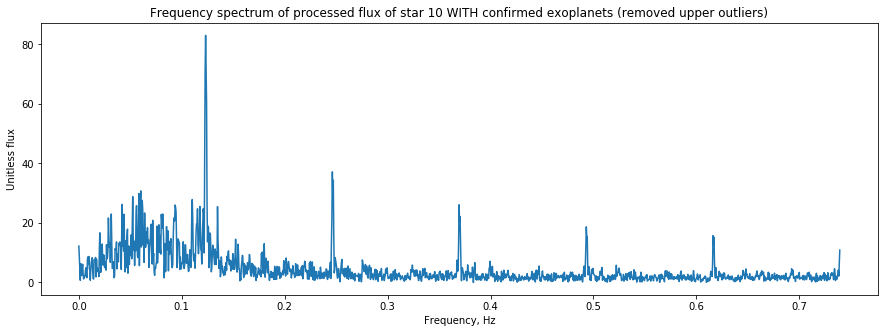

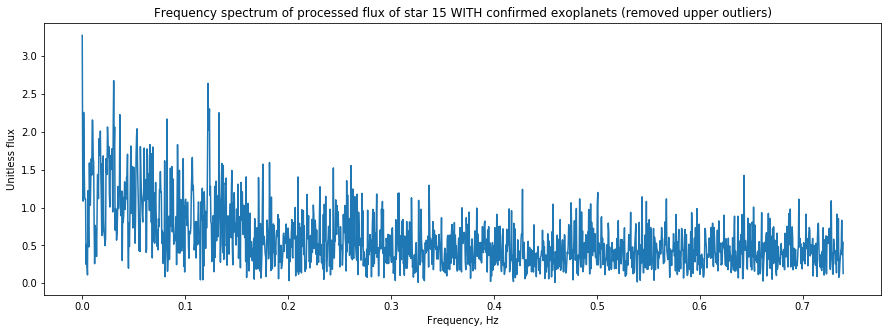

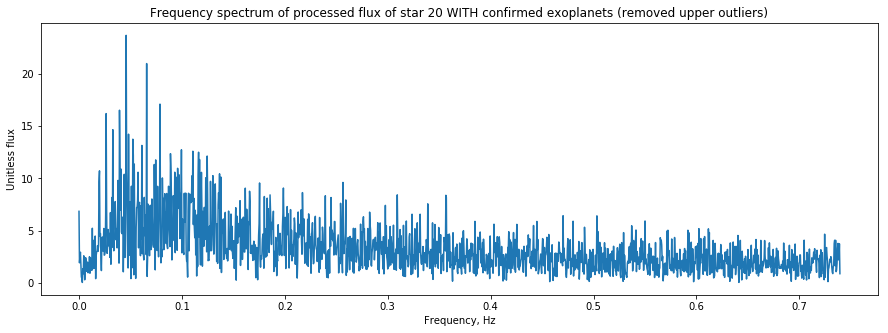

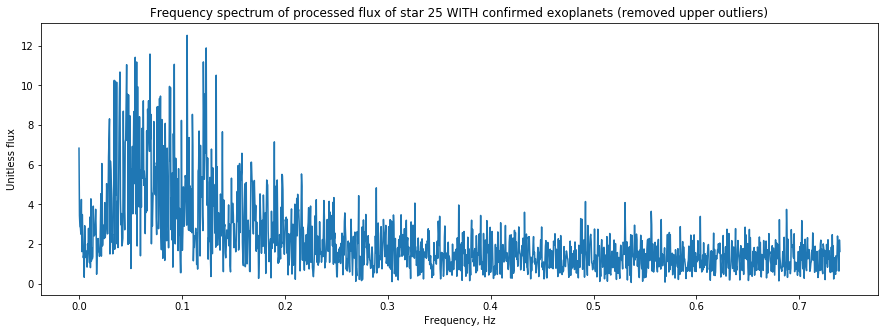

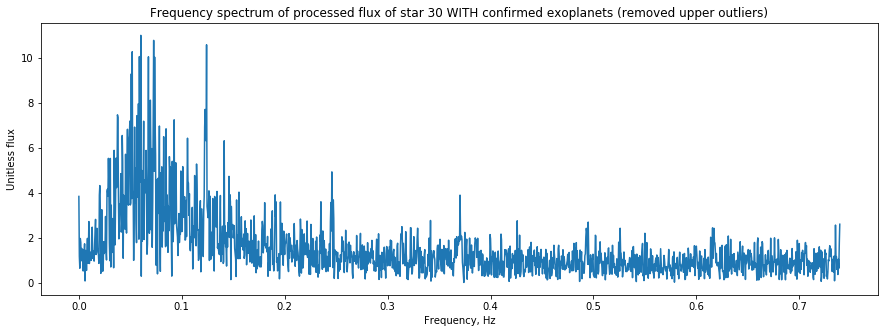

In [42]:
# Obtaining flux frequency spectra for several stars with exoplanets from the train data:
df = X.join(y)
for i in [0, 9, 14, 19, 24, 29]:
    spec1 = df[df.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
    freq = np.arange(len(spec1)) * (1/(36.0*60.0)) # Sampling frequency is 1 frame per ~36 minutes, or about 0.00046 Hz
    plt.figure(figsize=(15,5))
    plt.title('Frequency spectrum of processed flux of star {} WITH confirmed exoplanets (removed upper outliers)'
              .format(i+1))
    plt.ylabel('Unitless flux')
    plt.xlabel('Frequency, Hz')
    plt.plot(freq, spec1)

There is a noticeable bump on the left side of spectra for stars with exoplanets, so we may have a chance at improving our models, after all!  
But first, let's do a little housekeeping.

In [73]:
X.columns

Index([u'FLUX.1', u'FLUX.2', u'FLUX.3', u'FLUX.4', u'FLUX.5', u'FLUX.6',
       u'FLUX.7', u'FLUX.8', u'FLUX.9', u'FLUX.10',
       ...
       u'FLUX.1589', u'FLUX.1590', u'FLUX.1591', u'FLUX.1592', u'FLUX.1593',
       u'FLUX.1594', u'FLUX.1595', u'FLUX.1596', u'FLUX.1597', u'FLUX.1598'],
      dtype='object', length=1598)

Let's convert column names to frequencies they represent.

In [74]:
X_columns = np.arange(len(X.columns))
X_columns = X_columns * (1.0/(36.0*60.0)) # sampling frequency of our data
X.columns = X_columns
X_final_test.columns = X_columns

In [75]:
X.columns

Float64Index([              0.0, 0.000462962962963, 0.000925925925926,
               0.00138888888889,  0.00185185185185,  0.00231481481481,
               0.00277777777778,  0.00324074074074,   0.0037037037037,
               0.00416666666667,
              ...
                 0.735185185185,    0.735648148148,    0.736111111111,
                 0.736574074074,    0.737037037037,            0.7375,
                 0.737962962963,    0.738425925926,    0.738888888889,
                 0.739351851852],
             dtype='float64', length=1598)

Now, let's do some modeling with our new and improved features!

## Modeling

In [76]:
model_evaluator(X, y, LinearSVC())

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
Average Accuracy
0.991155654905
Average Precision
0.395357142857
Average Recall
0.583333333333


No huge improvements, although having a precision of 0.7 on KNN model trained with bootstrapped data is very nice considering limited resources. Let's see if normalizing spectra can make any positive difference:

In [77]:
from sklearn.preprocessing import normalize

In [109]:
X = pd.DataFrame(normalize(X))
X_final_test = pd.DataFrame(normalize(X_final_test))

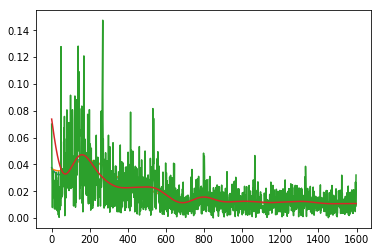

In [102]:
# # First, design the Buterworth filter
# N  = 4    # Filter order
# Wn = 0.01 # Cutoff frequency
# B, A = signal.butter(N, Wn, output='ba')

# plt.plot(X.iloc[0])

# for i in range(len(X.index) ):
#     X.iloc[i] = signal.filtfilt(B, A, X.iloc[i])

# plt.plot(X.iloc[0])

# plt.plot(X_final_test.iloc[0])

# for i in range(len(X_final_test.index) ):
#     X_final_test.iloc[i] = signal.filtfilt(B, A, X_final_test.iloc[i])

# plt.plot(X_final_test.iloc[0])

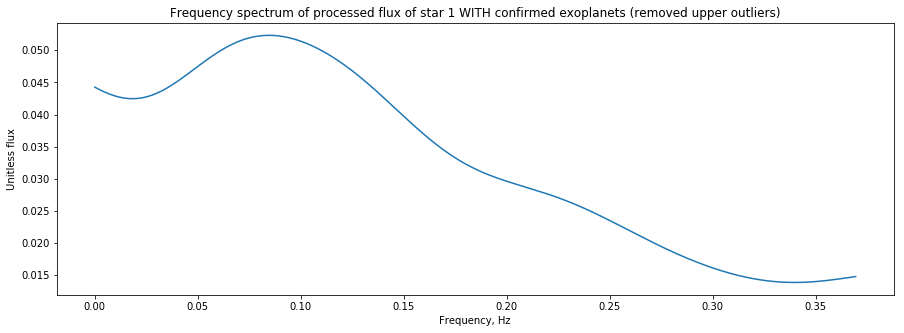

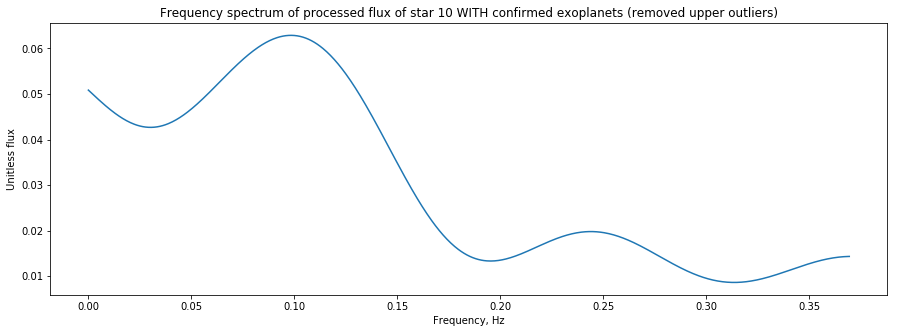

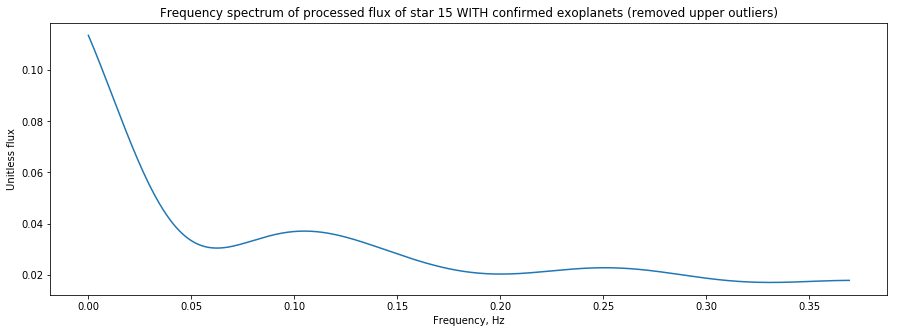

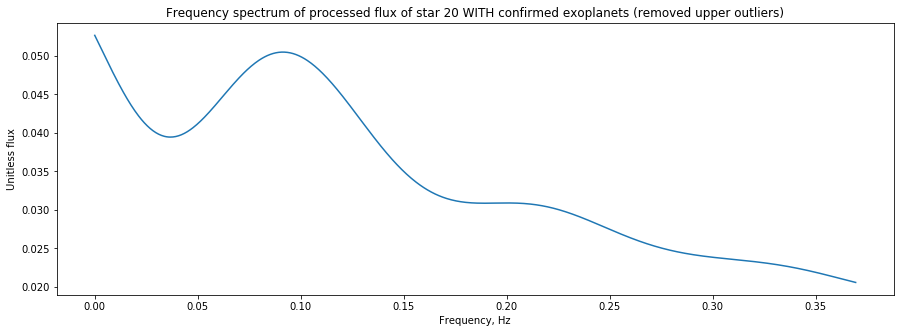

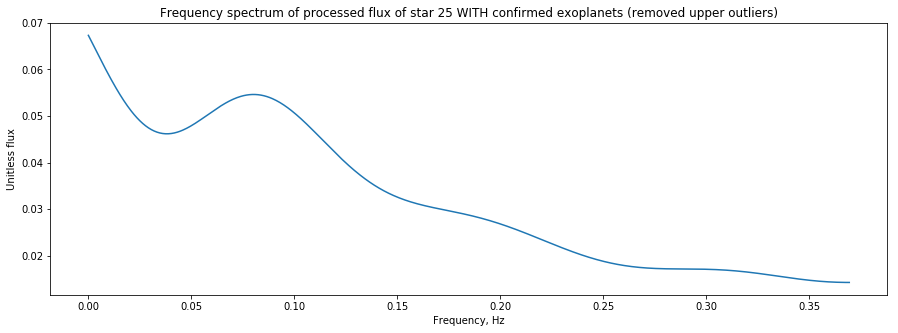

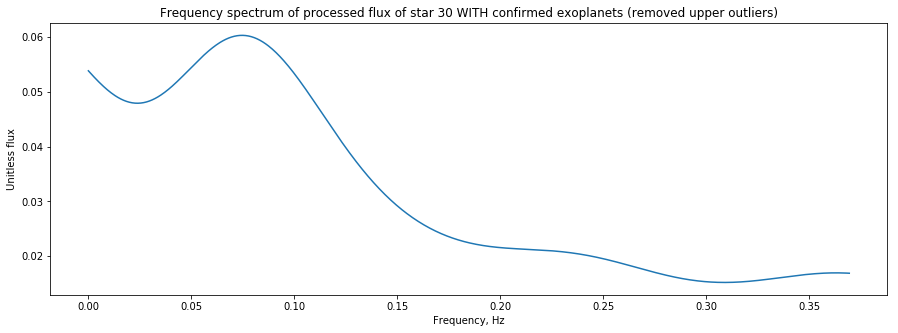

In [110]:
# Obtaining flux frequency spectra for several stars with exoplanets from the train data:
df = X.join(y)
for i in [0, 9, 14, 19, 24, 29]:
    spec1 = df[df.LABEL == 2].drop('LABEL', axis=1).iloc[i,:]
    freq = np.arange(len(spec1)) * (1/(36.0*60.0)) # Sampling frequency is 1 frame per ~36 minutes, or about 0.00046 Hz
    plt.figure(figsize=(15,5))
    plt.title('Frequency spectrum of processed flux of star {} WITH confirmed exoplanets (removed upper outliers)'
              .format(i+1))
    plt.ylabel('Unitless flux')
    plt.xlabel('Frequency, Hz')
    plt.plot(freq, spec1)

In [104]:
model_evaluator(X, y, LinearSVC())

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
Average Accuracy
0.853934300698
Average Precision
0.0433105872276
Average Recall


Looks like we found our model to optimize! We can now look closely at Linear Support Vector Classification and find most optimal parameters for it via randomized and grid searches. Perhaps, we can improve the recall rate.  
## Linear SVC Optimization through Randomized and Grid Searches

Let's see if the Randomized Search works with our data without taking it through SMOTE process. For that I will be setting `class_weight` parameter in `LinearSVC` classifier to `'balanced'`. Also, I am unsure how to tell Randomized Search that I am looking for LABEL = 2, so to avoid any confusion, I will convert all 1s to 0s and all 2s to 1s:

Let's see if we can do better with SMOTE data balancing. This time `class_weight` is going to be `None` since the data will be balanced through synthetic data generation:

In [ ]:
def SMOTE_synthesizer(X, y):
        sm = SMOTE(ratio = 1.0)
        X, y = sm.fit_sample(X, y)
        return X, y

So at the end of the day, it still looks like training on synthetic data works better than balancing. For models trained with SMOTE data, my best `precision`, `recall`, and `f1` scores were `1.00`, `0.47`, and `0.64`, respectively. For models that try to balance training data, my best `precision`, `recall`, and `f1` scores were `1.00`, `0.37`, and `0.54`, respectively. The best scores for SMOTE trained models were achieved with the following parameters:
```python
LinearSVC(
    C=100.0,
    class_weight=None,
    dual=True,
    fit_intercept=True,
    intercept_scaling=10,
    loss='hinge',
    max_iter=100000,
    multi_class='ovr',
    penalty='l2',
    random_state=None,
    tol=0.0001,
    verbose=0)```
Therefore, we shall now proceed with the Grid Search to zoom in on possible settings around these parameters:

In [85]:
def SMOTE_synthesizer(X, y):
        sm = SMOTE(ratio = 1.0)
        X, y = sm.fit_sample(X, y)
        return X, y

Unfortunately, none of the parameter searches yielded results better than our initial default LinearSVC() model. Therefore, we shall proceed and create our final model uising default parameters of LinearSVC():

## Final Model

In [86]:
X_sm, y_sm = SMOTE_synthesizer(X, y)

/Users/abalakrishna/.local/lib/python2.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [87]:
final_model = LinearSVC()
final_model.fit(X_sm, y_sm)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [88]:
y_pred = final_model.predict(X_final_test)

In [89]:
from sklearn.metrics import classification_report
print(classification_report(y_final_test, y_pred))

             precision    recall  f1-score   support

          1       1.00      1.00      1.00       565
          2       0.75      0.60      0.67         5

avg / total       0.99      0.99      0.99       570



This is a good precision and recall, especially in comparison with earlier baseline models. It will be interesting to see the adoption of such approach to star flux analysis in further K2 campaigns.